# Análisis de Texto en Python: Bolsa de Palabras

* * * 
### Reto Elaborado Por:
* Carlos Manrique Cachimuel
* Christian Sangucho Diaz
* Hector Mena Cornejo
* Henry Acosta Castro
* Jimmy Puente Quinga

<div class="alert alert-success">  
    
### Objetivos de aprendizaje
    
* Aprenda a convertir datos de texto en números mediante un enfoque de Bolsa de Palabras.
* Comprenda el algoritmo TF-IDF y cómo complementa la representación de Bolsa de Palabras.
* Implemente Bolsa de Palabras y TF-IDF con el paquete sklearn y comprenda su configuración de parámetros.
* Utilice las representaciones numéricas de datos de texto para realizar análisis de sentimientos.
</div>

### Iconos utilizados en este cuaderno
🔔 **Question**: Una pregunta rápida para ayudarte a entender qué está pasando.<br>
🥊 **Challenge**: Ejercicios interactivos. Los trabajaremos en el taller!<br>
🎬 **Demo**: Mostrando algo más avanzado: para que sepas para qué se puede usar Python!<br> 

### Sections
1. [Análisis Exploratorio de Datos](#section1)
2. [Preprocesamiento](#section2)
3. [La representación de la bolsa de palabras](#section3)
4. [Frecuencia de término-Frecuencia de documento inversa](#section4)
5. [Clasificación de sentimientos mediante la representación TF-IDF](#section5)

En la parte anterior, aprendimos cómo realizar la preprocesamiento de texto. Sin embargo, no fuimos más allá de los propios datos de texto. Si queremos hacer algún análisis computacional sobre los datos de texto, aún necesitamos métodos para convertir el texto en una representación numérica.

En la Parte 2 de nuestra serie de talleres, exploraremos una de las formas más simples de generar una representación numérica a partir del texto: la Bolsa de Palabras (Bag of Words, BoW). Implementaremos esta representación para transformar nuestros datos de tweets sobre aerolíneas y luego construiremos un clasificador para explorar qué nos dice sobre el sentimiento de los tweets.

En el centro del enfoque de la bolsa de palabras está la suposición de que la frecuencia de ciertos tokens (palabras o frases) es informativa sobre la semántica y el sentimiento subyacente en el texto.

Haremos un uso intensivo del paquete `scikit-learn` para lograrlo, ya que proporciona un buen marco para construir la representación numérica.

¡Primero instalemos `scikit-learn`!

In [ ]:
# Uncomment to install the package
#%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Uncomment to install the NLP packages introduced in Part 1
# Descomenta para instalar los paquetes de NLP presentados en la Parte 1
#%pip install NLTK
#%pip install spaCy
#!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.9 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Import other packages
# Importar otros paquetes
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

<a id='section1'></a>

# Análisis Exploratorio de Datos

Antes de realizar cualquier preprocesamiento o modelado, siempre debemos realizar un análisis exploratorio de datos para familiarizarnos con los datos.

In [3]:
# Read in data
# Leer los datos
tweets_path = '../data/airline_tweets.csv'
tweets = pd.read_csv(tweets_path, sep=',')

In [4]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Como recordatorio, cada fila de este marco de datos corresponde a un tuit. Las siguientes columnas son de gran interés. Hay otras columnas que contienen metadatos del tuit, como el autor, la fecha de creación, la zona horaria del usuario y otros, que dejaremos de lado por ahora.

- `text` (`str`): El texto del tuit.
- `airline_sentiment` (`str`): El sentimiento del tuit, etiquetado como "neutral", "positivo" o "negativo".
- `airline` (`str`): tLa aerolínea sobre la que se tuitea.
- `retweet count` (`int`): Cuántas veces se retuiteó el tuit.

Para prepararnos para la clasificación de sentimientos, dividiremos el conjunto de datos para centrarnos en los tweets "positivos" y "negativos" por ahora.

In [5]:
tweets = tweets[tweets['airline_sentiment'] != 'neutral'].reset_index(drop=True)

¡Primero echemos un vistazo a algunos tweets!

In [6]:
# Print first five tweets
# Imprimimos los cinco primeros tweets
for idx in range(5):
    print(tweets['text'].iloc[idx])

@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)



Ya podemos ver que algunos de estos tuits contienen sentimientos negativos: ¿cómo podemos saber que este es el caso?

A continuación, echemos un vistazo a la distribución de las etiquetas de sentimiento en este conjunto de datos.

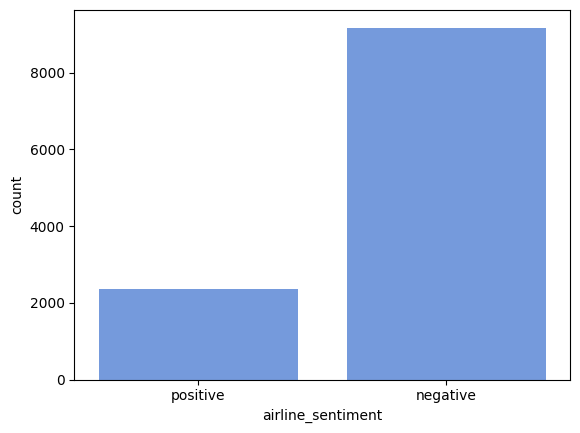

In [7]:
# Make a bar plot showing the count of tweet sentiments
sns.countplot(data=tweets,
              x='airline_sentiment', 
              color='cornflowerblue',
              order=['positive', 'negative']);

¡Parece que la mayoría de los tweets en este conjunto de datos expresan un sentimiento negativo!


Veamos qué es lo que recibe más retuits:

In [8]:
# Get the mean retweet count for each sentiment
# Obtenga el recuento promedio de retuits para cada sentimiento
tweets.groupby('airline_sentiment')['retweet_count'].mean()

airline_sentiment
negative    0.093375
positive    0.069403
Name: retweet_count, dtype: float64

¡Los tweets negativos son claramente retuiteados con más frecuencia que los positivos!


Veamos qué aerolínea recibe más tweets negativos:

In [9]:
# Get the proportion of negative tweets by airline
# Obtenga la proporción de tweets negativos por aerolínea
proportions = tweets.groupby(['airline', 'airline_sentiment']).size() / tweets.groupby('airline').size()
proportions.unstack().sort_values('negative', ascending=False)

airline_sentiment,negative,positive
airline,,
US Airways,0.893760,0.106240
American,0.853659,0.146341
United,0.842560,0.157440
Southwest,0.675399,0.324601
Delta,0.637091,0.362909
Virgin America,0.543544,0.456456


Parece que la gente está más insatisfecha con US Airways, seguida de American Airlines, ¡ambos con más del 85% de tweets negativos!

Se podrían hacer muchos descubrimientos interesantes si se desea explorar más sobre los datos. Ahora volvamos a nuestra tarea de análisis de sentimientos. Antes de eso, necesitamos preprocesar los datos de texto para que estén en un formato estándar.

<a id='section2'></a>
# Preprocesamiento

Dedicamos gran parte de la Parte 1 a aprender a preprocesar datos. ¡Apliquemos lo aprendido! Al observar algunos de los tuits anteriores, vemos que, aunque están en buen estado, podemos procesarlos mejor.

En nuestro pipeline, omitiremos el proceso de tokenización ya que lo realizaremos en un paso posterior.

## 🥊 Desafío 1: Aplicar una canalización de limpieza de texto

Escriba una función llamada `preprocess` que realice los siguientes pasos en una entrada de texto:


* Paso 1: Convierte el texto en minúsculas.
* Paso 2: Reemplaza los siguientes patrones con marcadores de posición:
* URLs &rarr; ` URL `
* Dígitos &rarr; ` DIGIT `
* Hashtags &rarr; ` HASHTAG `
* Usuarios de tweets &rarr; ` USER `
* Paso 3: Elimina los espacios en blanco.

A continuación se ofrecen algunos consejos para guiarlo en este desafío:


* Para el Paso 1, recuerda de la Parte 1 que se puede usar un método de cadena llamado [`.lower()`](https://docs.python.org/3.11/library/stdtypes.html#str.lower) para convertir texto a minúsculas.
* Hemos integrado el Paso 2 en una función llamada `placeholder`. Ejecuta la celda a continuación para importarla a tu notebook y podrás usarla como cualquier otra función.
* Para el Paso 3, proporcionamos el patrón de expresiones regulares para identificar espacios en blanco, así como el reemplazo correcto para extraer espacios en blanco.


Ejecute la función `preprocess` en `example_tweet` (tres celdas más abajo) para comprobar si funciona. De ser así, aplíquela a toda la columna `text` del dataframe de tweets.

In [10]:
from utils import placeholder

In [11]:
blankspace_pattern = r'\s+'
blankspace_repl = ' '

def preprocess(text):
    '''Create a preprocess pipeline that cleans the tweet data.'''

    # Step 1: Lowercase
    # Paso 1: Minúsculas
    text = text.lower()

    # Step 2: Replace patterns with placeholders
    # Paso 2: Reemplazar patrones con marcadores de posición
    text = placeholder(text)

    # Step 3: Remove extra whitespace characters
    # Paso 3: Eliminar caracteres de espacio en blanco adicionales
    text = re.sub(blankspace_pattern, blankspace_repl, text)
    text = text.strip()
    
    return text

In [12]:
example_tweet = 'lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo'

# Print the example tweet
# Imprima el tweet de ejemplo
print(example_tweet)
print(f"{'='*50}")

# Print the preprocessed tweet
# Imprima el tweet preprocesado
print(preprocess(example_tweet))

lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo
lol USER and USER are like soo DIGIT HASHTAG HASHTAG saw it on URL HASHTAG


In [13]:
# Apply the function to the text column and assign the preprocessed tweets to a new column
# Aplique la función a la columna de texto y asigne los tweets preprocesados ​​a una nueva columna
tweets['text_processed'] = tweets['text'].apply(lambda x: preprocess(x))
tweets['text_processed'].head()

0    USER plus you've added commercials to the expe...
1    USER it's really aggressive to blast obnoxious...
2        USER and it's a really big bad thing about it
3    USER seriously would pay $ DIGIT a flight for ...
4    USER yes, nearly every time i fly vx this “ear...
Name: text_processed, dtype: object

¡Felicitaciones! El preprocesamiento está listo. ¡Adentrémonos en el mundo de las palabras!

<a id='section3'></a>
# La representación de la bolsa de palabras

La idea de la bolsa de palabras (BoW), como su nombre indica, es bastante intuitiva: tomamos un documento y lo metemos en una bolsa. Esta acción ignora la posición relativa entre las palabras, por lo que lo que está "en la bolsa" es esencialmente un conjunto de palabras sin clasificar. [(Jurafsky & Martin, 2024)](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf). A cambio, tenemos una lista de palabras únicas y la frecuencia de cada una de ellas.

Por ejemplo, como se muestra en la siguiente ilustración, la palabra "café" aparece dos veces.

<img src='../images/bow-illustration-1.png' alt="BoW-Part2" width="600">

Con una representación de bolsa de palabras, hacemos un uso intensivo de la frecuencia de las palabras, pero no demasiado del orden de las palabras.

En el contexto del análisis de sentimientos, el sentimiento de un tuit se transmite con mayor fuerza mediante palabras específicas. Por ejemplo, si un tuit contiene la palabra "feliz", probablemente transmita un sentimiento positivo, pero no siempre (p. ej., "no feliz" denota el sentimiento opuesto). Cuanto más frecuentes sean estas palabras, probablemente transmitan el sentimiento con mayor fuerza.

## Matriz de términos del documento

Ahora implementemos la idea de la bolsa de palabras. Antes de profundizar, retrocedamos un momento. En la práctica, el análisis de texto suele implicar la gestión de muchos documentos; de ahora en adelante, usaremos el término **documento** para representar el fragmento de texto que analizamos. Puede ser una frase, una oración, un tuit o cualquier otro texto; siempre que pueda representarse mediante una cadena, la longitud no importa.

Imaginemos que tenemos cuatro documentos (es decir, las cuatro frases mostradas arriba) y los metemos todos en la bolsa. En lugar de una lista de frecuencia de palabras, esperaríamos obtener una matriz de términos de documento (DTM). En una DTM, la lista de palabras es el **vocabulario** (V) que contiene todas las palabras únicas que aparecen en los documentos. Para cada **documento** (D), contamos el número de ocurrencias de cada palabra en el vocabulario y luego introducimos el número en la matriz. En otras palabras, la MDT que construiremos es una matriz $D \times V$, donde cada fila corresponde a un documento y cada columna a un token (o "término").

Los tokens únicos de este conjunto de documentos, ordenados alfabéticamente, forman las columnas. Para cada documento, marcamos la ocurrencia de cada palabra presente en él. La representación numérica de cada documento es una fila en la matriz. Por ejemplo, el primer documento, "el tostador de café", tiene la representación numérica $[0, 1, 0, 0, 0, 1, 1, 0]$.

Observe que la columna de índice izquierda ahora muestra estos documentos como texto, pero normalmente solo asignaríamos un índice a cada uno de ellos.

$$
\begin{array}{c|cccccccccccc}
 & \text{americano} & \text{coffee} & \text{iced} & \text{light} & \text{roast} & \text{roaster} & \text{the} & \text{time} \\\hline
\text{the coffee roaster} &0 &1	&0	&0	&0	&1	&1	&0 \\ 
\text{light roast} &0 &0	&0	&1	&1	&0	&0	&0 \\
\text{iced americano} &1 &0	&1	&0	&0	&0	&0	&0 \\
\text{coffee time} &0 &1	&0	&0	&0	&0	&0	&1 \\
\end{array}
$$

Para crear un DTM, utilizaremos `CountVectorizer` del paquete `sklearn`.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

La siguiente ilustración muestra el flujo de trabajo de tres pasos para crear un DTM con `CountVectorizr`.

<img src='../images/CountVectorizer1.png' alt="CountVectorizer" width="500">

Repasemos estos pasos con el ejemplo de juguete que se muestra arriba.

### A Toy Example

In [15]:
# A toy example containing four documents
# Un ejemplar de juguete que contiene cuatro documentos.
test = ['the coffee roaster',
        'light roast',
        'iced americano',
        'coffee time']

El primer paso es inicializar un objeto `CountVectorizer`. Dentro de los parágrafos circulares, podemos especificar la configuración de los parámetros si lo deseamos. Consultemos la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) para ver qué opciones están disponibles.

Por ahora podemos dejarlo en blanco para utilizar la configuración predeterminada.

In [16]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()

El segundo paso es ajustar este objeto `CountVectorizer` a los datos, lo que implica crear un vocabulario de tokens a partir del conjunto de documentos. En tercer lugar, transformamos nuestros datos según el objeto `CountVectorizer` ajustado, lo que implica tomar cada documento y contar las ocurrencias de tokens según el vocabulario establecido durante el paso de ajuste.

Puede parecer un poco complejo, pero los pasos 2 y 3 se pueden realizar de una sola vez mediante la función `fit_transform`.

In [17]:
# Fit and transform to create a DTM
# Ajustar y transformar para crear un DTM
test_count = vectorizer.fit_transform(test)

Se supone que el retorno de `fit_transform` es el DTM.

¡Echémosle un vistazo!

In [18]:
test_count

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 9 stored elements and shape (4, 8)>

Aparentemente, tenemos una "matriz dispersa", es decir, una matriz con muchos ceros. Esto tiene sentido. En cada documento, hay palabras que no aparecen, y estas se contabilizan como cero en el DTM. Esta matriz dispersa se almacena en formato de "fila dispersa comprimida", un formato que ahorra memoria y está diseñado para manejar matrices dispersas.

Convirtámosla en una matriz densa, donde probablemente esos ceros estén representados, como en un array numpy.

In [19]:
# Convert DTM to a dense matrix 
# Convertir DTM en una matriz densa
test_count.todense()

matrix([[0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1]])

¡Así que este es nuestro DTM! La matriz es la misma que se muestra arriba. Para que sea más legible, la convertiremos en un dataframe. Los nombres de las columnas deben ser tokens en el vocabulario, a los que podemos acceder con la función `get_feature_names_out`.

In [20]:
# Retrieve the vocabulary
# Recuperar el vocabulario
vectorizer.get_feature_names_out()

array(['americano', 'coffee', 'iced', 'light', 'roast', 'roaster', 'the',
       'time'], dtype=object)

In [21]:
# Create a DTM dataframe
# Crear un marco de datos DTM
test_dtm = pd.DataFrame(data=test_count.todense(),
                        columns=vectorizer.get_feature_names_out())

¡Aquí está! El DTM de nuestros datos de juguete ahora es un marco de datos. El índice de `test_dtm` corresponde a la posición de cada documento en la lista `test`.

In [22]:
test_dtm

,americano,coffee,iced,light,roast,roaster,the,time
0,0,1,0,0,0,1,1,0
1,0,0,0,1,1,0,0,0
2,1,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,1


Esperamos que este ejemplo de juguete ofrezca una guía clara sobre cómo crear un DTM.

¡Ahora es el momento de analizar los datos de nuestros tuits!

### DTM para tweets

Comenzaremos inicializando un objeto `CountVectorizer`. En la siguiente celda, incluimos algunos parámetros que se ajustan con frecuencia. Estos parámetros están configurados con sus valores predeterminados.

Al construir un DTM, el texto de entrada se escribe en minúsculas por defecto. Si no se especifica nada para `stop_words`, se conservan por defecto. Los siguientes tres parámetros controlan el tamaño del vocabulario, tema que abordaremos en breve.

In [23]:
# Create a CountVectorizer object
# Crear un objeto CountVectorizer
vectorizer = CountVectorizer(lowercase=True,
                             stop_words=None,
                             min_df=1,
                             max_df=1.0, 
                             max_features=None)

In [24]:
# Fit and transform to create DTM
# Ajustar y transformar para crear DTM
counts = vectorizer.fit_transform(tweets['text_processed'])
counts

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 191139 stored elements and shape (11541, 8751)>

In [25]:
# Do not run if you have limited memory - this includes DataHub and Binder
# No lo ejecute si tiene memoria limitada: esto incluye DataHub y Binder
np.array(counts.todense())

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(11541, 8751))

In [26]:
# Extract tokens
# Extraer tokens
tokens = vectorizer.get_feature_names_out()

In [27]:
# Create DTM
# Crear DTM
first_dtm = pd.DataFrame(data=counts.todense(),
                         index=tweets.index,
                         columns=tokens)

# Print the shape of DTM
# Imprima la forma del DTM
print(first_dtm.shape)

(11541, 8751)


Si dejamos `CountVectorizer` con la configuración predeterminada, el tamaño del vocabulario de los datos del tweet es 8751.

In [28]:
first_dtm.head()

,_exact_,_wtvd,aa,aaaand,aadv,aadvantage,aal,aaron,ab,aback,...,zero,zig,zip,zippers,zone,zones,zoom,zukes,zurich,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La mayoría de los tokens no aparecen en al menos los primeros cinco tuits.

¡Echemos un vistazo más de cerca al DTM!

In [29]:
# Most frequent tokens
# Tokens más frecuentes
first_dtm.sum().sort_values(ascending=False).head(10)

user      12882
to         6987
digit      6927
the        5088
you        3635
for        3386
flight     3320
and        3276
on         3142
my         2751
dtype: int64

In [30]:
# Least frequent tokens
# Tokens menos frecuentes
first_dtm.sum().sort_values(ascending=True).head(10)

zones         1
accelerate    1
acc           1
acarl         1
yogurt        1
yoga          1
yikes         1
absurdity     1
absorber      1
absorb        1
dtype: int64

No sorprende que "usuario" y "dígito" se encuentren entre los tokens más frecuentes, ya que reemplazamos cada uno específico con estos marcadores. El resto de los tokens más frecuentes son principalmente palabras vacías.

Quizás un patrón más interesante sea buscar qué token aparece con más frecuencia en un tuit determinado:

In [31]:
counts = pd.DataFrame()

# Retrieve the index of the tweet where a token appears most frequently
# Recuperar el índice del tweet donde aparece con mayor frecuencia un token
counts['token'] = first_dtm.idxmax(axis=1)

# Retrieve the number of occurrence 
# Recuperar el número de ocurrencia
counts['number'] = first_dtm.max(axis=1)

# Filter out placeholders
# Filtrar marcadores de posición
counts[(counts['token']!='digit')
       & (counts['token']!='hashtag')
       & (counts['token']!='user')].sort_values('number', ascending=False).head(10)

,token,number
3127,lt,6
918,worst,6
11007,to,5
5513,to,5
7750,to,5
10923,the,5
4089,to,5
8134,to,5
8148,the,5
557,to,5


Parece que, entre todos los tuits, un token aparece como máximo seis veces, y se trata de la palabra "It" o de la palabra "worst".

Regresemos a nuestro marco de datos de tuits y localicemos el tuit número 918.

In [32]:
# Retrieve 918th tweet: "worst"
# Recuperar el tweet número 918: "worst"
tweets.iloc[918]['text']

"@united is the worst. Worst reservation policies. Worst costumer service. Worst worst worst. Congrats, @Delta you're not that bad!"

## Personaliza el `CountVectorizer`

Hasta ahora, siempre hemos usado la configuración predeterminada para crear nuestros DTM, pero en muchos casos, podemos querer personalizar el objeto `CountVectorizer`. El objetivo es filtrar aún más los tokens innecesarios. En el siguiente ejemplo, ajustamos los siguientes parámetros:

- `stop_words = 'english'`: ignorar las palabras vacías en inglés
- `min_df = 2`: ignorar las palabras que no aparecen al menos dos veces
- `max_df = 0.95`: ignorar las palabras que aparecen en más del 95% de los documentos

🔔 **Question**: Detengámonos un momento para analizar si es razonable establecer estos parámetros. ¿Qué opinan?

A menudo, no nos interesan las palabras con frecuencias demasiado bajas o demasiado altas, por lo que usamos `min_df` y `max_df` para filtrarlas. Como alternativa, podemos definir el tamaño de nuestro vocabulario como $N$ configurando `max_features`. En otras palabras, le indicamos a `CountVectorizer` que solo considere los $N$ tokens más frecuentes al construir el DTM.

In [33]:
# Customize the parameter setting
# Personalizar la configuración de parámetros
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [34]:
# Fit, transform, and get tokens
# Ajusta, transforma y obtén tokens
counts = vectorizer.fit_transform(tweets['text_processed'])
tokens = vectorizer.get_feature_names_out()

# Create the second DTM
# Crear el segundo DTM
second_dtm = pd.DataFrame(data=counts.todense(),
                          index=tweets.index,
                          columns=tokens)

Nuestro segundo DTM tiene un vocabulario sustancialmente más pequeño en comparación con el primero.

In [35]:
print(first_dtm.shape)
print(second_dtm.shape)

(11541, 8751)
(11541, 4471)


In [36]:
second_dtm.head()

,aa,aadv,aadvantage,aal,abandoned,abc,ability,able,aboard,abq,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La lista de tokens más frecuentes ahora incluye palabras que tienen más sentido para nosotros, como "cancelado" y "servicio".

In [37]:
second_dtm.sum().sort_values(ascending=False).head(10)

digit        6927
flight       3320
hashtag      2633
cancelled     956
thanks        921
service       910
just          801
customer      726
time          695
help          687
dtype: int64

## 🥊 Desafío 2: Lematizar la entrada de texto

Recuerda que en la Parte 1 introdujimos el uso de `spaCy` para realizar lematización, es decir, para recuperar la forma base de una palabra. Este proceso reducirá el tamaño del vocabulario al minimizar las variaciones de las palabras; un vocabulario más pequeño puede ayudar a mejorar el rendimiento del modelo en la clasificación de sentimientos.

Ahora implementemos la lematización en nuestros datos de tweets y usemos el texto lematizado para crear un tercer DTM.

Completa la función `lemmatize_text`. Requiere una entrada de texto y devuelve los lemas de todos los tokens.

Aquí tienes algunas sugerencias para guiarte en este desafío:

- Paso 1: Inicializa una lista para almacenar los lemas
- Paso 2: Aplica la secuencia `nlp` al texto de entrada
- Paso 3: Itera sobre los tokens en el texto procesado y recupera el lema del token
    - SUGERENCIA: La lematización es una de las anotaciones lingüísticas que la secuencia `nlp` realiza automáticamente. Podemos usar `token.lemma_` para acceder a la anotación.

In [38]:
# Import spaCy
import spacy
nlp = spacy.load('en_core_web_sm')

In [48]:
# Create a function to lemmatize text
# Crear una función para lematizar texto
def lemmatize_text(text):
    '''Lemmatize the text input with spaCy annotations.'''

    # Step 1: Initialize an empty list to hold lemmas
    # Paso 1: Inicializar una lista vacía para contener lemas
    lemma = []

    # Step 2: Apply the nlp pipeline to input text
    # Paso 2: Aplicar la canalización de PNL al texto de entrada
    doc = nlp(text)

    # Step 3: Iterate over tokens in the text to get the token lemma
    # Paso 3: Iterar sobre los tokens en el texto para obtener el lema del token
    for token in doc:
        lemma.append(token.lemma_)

    # Step 4: Join lemmas together into a single string
    # Paso 4: Unir lemas para formar una sola cadena
    text_lemma = ' '.join(lemma)

    return text_lemma

¡Primero apliquemos la función al siguiente tweet de ejemplo!

In [49]:
# Apply the function to an example tweet
# Aplicar la función a un tweet de ejemplo
print(tweets.iloc[33]["text_processed"])
print(f"{'='*50}")
print(lemmatize_text(tweets.iloc[33]['text_processed']))

USER wow this just blew my mind
USER wow this just blow my mind


Y luego lematizaremos los datos del tweet y guardaremos la salida en una nueva columna "text_lemmatized".

In [50]:
# This may take a while!
# ¡Esto puede tardar un poco!
tweets['text_lemmatized'] = tweets['text_processed'].apply(lambda x: lemmatize_text(x))

Ahora, con la columna `text_lemmatized`, crearemos un tercer DTM. La configuración de parámetros es la misma que la del segundo DTM.

In [51]:
# Create the vectorizer (the same param setting as previous)
# Crea el vectorizador (la misma configuración de parámetros que la anterior)
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

# Fit, transform, and get tokens
# Ajustar, transformar y obtener tokens
counts = vectorizer.fit_transform(tweets['text_lemmatized'])
tokens = vectorizer.get_feature_names_out()

# Create the third DTM
# Crea el tercer DTM
third_dtm = pd.DataFrame(data=counts.todense(),
                         index=tweets.index,
                         columns=tokens)
third_dtm.head()

,aa,aadv,aadvantage,aal,abandon,abc,ability,able,aboard,abq,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# Print the shapes of three DTMs
# Imprime las formas de tres DTM
print(first_dtm.shape)
print(second_dtm.shape)
print(third_dtm.shape)

(11541, 8751)
(11541, 4471)
(11541, 3571)


Imprimamos los 10 tokens más frecuentes como de costumbre. Estos tokens ahora son lemas y sus conteos también cambian después de la lematización.

In [53]:
# Get the most frequent tokens in the third DTM
# Obtenga los tokens más frecuentes en el tercer DTM
third_dtm.sum().sort_values(ascending=False).head(10)

digit       6927
flight      3951
hashtag     2633
thank       1453
hour        1134
cancel       949
service      939
delay        934
customer     902
time         860
dtype: int64

In [54]:
# Compared to the most frequent tokens in the second DTM
# En comparación con los tokens más frecuentes en el segundo DTM
second_dtm.sum().sort_values(ascending=False).head(10)

digit        6927
flight       3320
hashtag      2633
cancelled     956
thanks        921
service       910
just          801
customer      726
time          695
help          687
dtype: int64

<a id='section4'></a>

# Frecuencia de término-Frecuencia de documento inversa 

Hasta ahora, nos basamos en la frecuencia de palabras para obtener información sobre un documento. Esto supone que si una palabra aparece con más frecuencia en un documento, es más informativa. Sin embargo, esto no siempre es así. Por ejemplo, ya hemos eliminado las palabras vacías porque no son informativas, a pesar de aparecer muchas veces en un documento. También sabemos que la palabra "vuelo" es una de las más frecuentes, pero no es tan informativa, ya que aparece en muchos documentos. Dado que estamos analizando tuits de aerolíneas, ¡no debería sorprendernos ver la palabra "vuelo"!

Para solucionar esto, utilizamos un esquema de ponderación llamado **tf-idf (frecuencia de término-frecuencia inversa de documento)**. La idea principal de tf-idf es ponderar una palabra no solo por su frecuencia dentro de un documento, sino también por su frecuencia en un documento en relación con los demás. Por lo tanto, al construir el DTM, asignaremos a cada término una **puntuación tf-idf**. Específicamente, al término $t$ en el documento $d$ se le asigna una puntuación tf-idf de la siguiente manera:

<img src='../images/tf-idf_finalized.png' alt="TF-IDF" width="1200">

En esencia, la puntuación tf-idf de una palabra en un documento es el producto de dos componentes: la frecuencia de término (tf) y la frecuencia inversa de documento (idf). La idf actúa como un factor de escala. Si una palabra aparece en todos los documentos, la idf es igual a 1. No se produce escala. Sin embargo, la idf suele ser mayor que 1, que es el peso que asignamos a la palabra para aumentar la puntuación tf-idf y destacar su carácter informativo. En la práctica, sumamos 1 tanto al denominador como al numerador ("suavización de suma 1") para evitar problemas con cero ocurrencias.

También podemos crear un DTM tf-idf usando `sklearn`. En esta ocasión, usaremos `TfidfVectorizer`::

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
# Create a tfidf vectorizer
# Crear un vectorizador tfidf
vectorizer = TfidfVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [56]:
# Fit and transform 
# Ajustar y transformar
tf_dtm = vectorizer.fit_transform(tweets['text_lemmatized'])
tf_dtm

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 87904 stored elements and shape (11541, 3571)>

In [57]:
# Create a tf-idf dataframe
# Crear un marco de datos tf-idf
tfidf = pd.DataFrame(tf_dtm.todense(),
                     columns=vectorizer.get_feature_names_out(),
                     index=tweets.index)
tfidf.head()

,aa,aadv,aadvantage,aal,abandon,abc,ability,able,aboard,abq,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Quizás hayas notado que el tamaño del vocabulario es el mismo que vimos en el Desafío 2. Esto se debe a que usamos la misma configuración de parámetros al crear el vectorizador. Sin embargo, los valores de la matriz son diferentes: son puntuaciones tf-idf en lugar de conteos brutos.

## Interpretar valores TF-IDF

Analicemos el documento donde un término tiene los valores tf-idf más altos. Usaremos el método `.idxmax()` para encontrar el índice.

In [58]:
# Retrieve the index of the document
# Recuperar el índice del documento
tfidf.idxmax()

aa            10077
aadv           9285
aadvantage     9974
aal           10630
abandon        7859
              ...  
yyz            1350
zero           2705
zone           3177
zoom           3920
zurich        10622
Length: 3571, dtype: int64

Por ejemplo, el término "peor" aparece de forma más distintiva en el tuit número 918.

In [59]:
tfidf.idxmax()['worst']

np.int64(918)

¡Recordemos que este es el tweet donde la palabra “worst” aparece seis veces!

In [60]:
tweets['text_processed'].iloc[918]

"USER is the worst. worst reservation policies. worst costumer service. worst worst worst. congrats, USER you're not that bad!"

¿Qué tal "Cancel"? Veamos otro ejemplo.

In [61]:
tfidf.idxmax()['cancel']

np.int64(5945)

In [62]:
tweets['text_processed'].iloc[5945]

'USER cancelled flighted 😢'

## 🥊 Desafío 3: Palabras con las puntuaciones medias más altas en TF-IDF

Hemos obtenido valores tf-idf para cada término en cada documento. Pero ¿qué nos dicen estos valores sobre el sentimiento de los tuits? ¿Hay palabras que sean especialmente informativas para los tuits positivos/negativos?

Para explorar esto, recopilemos los índices de todos los tuits positivos/negativos y calculemos la media de las puntuaciones tf-idf de las palabras que aparecen en cada categoría.

Hemos proporcionado el siguiente código de inicio como guía:
- Cree un subconjunto del dataframe `tweets` según la etiqueta `airline_sentiment` y recupere el índice de cada subconjunto (`.index`). Asigne el índice a `positive_index` o `negative_index`. Para cada subconjunto:
- Obtener la representación td-idf
- Obtener la media de los valores tf-idf del subconjunto con `.mean()`
- Ordenar la media de los valores en orden descendente con `.sort_values()`
- Obtener los 10 términos principales con `.head()`

A continuación, ejecutar `pos.plot` y `neg.plot` para representar gráficamente las palabras con las puntuaciones medias tf-idf más altas para cada subconjunto.

In [63]:
vectorizer = TfidfVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [64]:
tf_dtm = vectorizer.fit_transform(tweets['text_lemmatized'])

In [65]:
tfidf = pd.DataFrame(tf_dtm.todense(),
                     columns=vectorizer.get_feature_names_out(),
                     index=tweets.index)

In [66]:
# Complete the boolean masks 
# Completa las máscaras booleanas
positive_index = tweets[tweets['airline_sentiment'] == 'positive'].index
negative_index = tweets[tweets['airline_sentiment'] == 'negative'].index

In [67]:
# Complete the following two lines
#Completa las dos líneas siguientes
pos = tfidf.loc[positive_index].mean().sort_values(ascending=False).head(10)
neg = tfidf.loc[negative_index].mean().sort_values(ascending=False).head(10)

: 

In [ ]:
pos.plot(kind='barh', 
         xlim=(0, 0.18),
         color='cornflowerblue',
         title='Top 10 terms with the highest mean tf-idf values for positive tweets');

In [ ]:
neg.plot(kind='barh', 
         xlim=(0, 0.18),
         color='darksalmon',
         title='Top 10 terms with the highest mean tf-idf values for negative tweets');

🔔 **Question**: How would you interpret these results? Share your thoughts in the chat!

<a id='section5'></a>

## 🎬 **Demo**: Clasificación de sentimientos mediante la representación TF-IDF

Ahora que tenemos una representación tf-idf del texto, ¡estamos listos para realizar el análisis de sentimientos!

En esta demostración, utilizaremos un modelo de regresión logística para realizar la tarea de clasificación. Aquí explicaremos brevemente cómo funciona la regresión logística como uno de los métodos de aprendizaje automático supervisado, pero no dude en explorar nuestro taller sobre [Python Machine Learning Fundamentals](https://github.com/dlab-berkeley/Python-Machine-Learning) Si quieres saber más sobre ello.

La regresión logística es un modelo lineal, con el que utilizamos para predecir la etiqueta de un tweet, en función de un conjunto de características ($x_1, x_2, x_3, ..., x_i$), como se muestra a continuación:

$$
L = \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_T x_T
$$

La lista de características que pasaremos al modelo es el vocabulario del DTM. También alimentamos el modelo con una parte de los datos, conocida como el conjunto de entrenamiento, junto con otras especificaciones del modelo, para obtener el coeficiente ($\beta_1, \beta_2, \beta_3, ..., \beta_i$) de cada característica. Los coeficientes nos indican si una característica contribuye positiva o negativamente al valor predicho. El valor predicho corresponde a la suma de todas las características (multiplicado por sus coeficientes), y el valor predicho se pasa a un [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) para convertirse al espacio de probabilidad, que nos dice si la etiqueta predicha es positiva (cuando $p>0.5$) o negativa (cuando $p<0.5$). 

La parte restante de los datos, conocida como el conjunto de prueba, se utiliza para comprobar si los coeficientes aprendidos pueden generalizarse a datos no vistos.

Ahora que ya tenemos el marco de datos tf-idf, el conjunto de características está listo. ¡Profundicemos en la especificación del modelo!

In [55]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

Usaremos la función `train_test_split` de `sklearn` para separar nuestros datos en dos conjuntos:

In [56]:
# Train-test split
# División de prueba y entrenamiento
X = tfidf
y = tweets['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

La función `fit_logistic_regression` se escribe a continuación para optimizar el proceso de entrenamiento.

In [57]:
def fit_logistic_regression(X, y):
    '''Fits a logistic regression model to provided data.'''
    model = LogisticRegressionCV(Cs=10,
                                 penalty='l1',
                                 cv=5,
                                 solver='liblinear',
                                 class_weight='balanced',
                                 random_state=42,
                                 refit=True).fit(X, y)
    return model

Ajustaremos el modelo y calcularemos la precisión del entrenamiento y la prueba.

In [58]:
# Fit the logistic regression model
# Ajuste el modelo de regresión logística
model = fit_logistic_regression(X_train, y_train)

In [59]:
# Get the training and test accuracy
# Obtenga la formación y la precisión de las pruebas
print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Test accuracy: {model.score(X_test, y_test)}")

Training accuracy: 0.9455601998164951
Test accuracy: 0.894919168591224


El modelo alcanzó una precisión de aproximadamente el 94 % en el conjunto de entrenamiento y del 89 % en el conjunto de prueba, ¡bastante buena! El modelo se generaliza razonablemente bien a los datos de prueba.

A continuación, analicemos también los coeficientes ajustados para comprobar si lo que vemos tiene sentido.

Podemos acceder a ellos mediante `coef_` y asociar cada coeficiente con los tokens del vectorizador:

In [60]:
# Get coefs of all features
# Obtener coeficientes de todas las características
coefs = model.coef_.ravel()

# Get all tokens
# Obtener todos los tokens
tokens = vectorizer.get_feature_names_out()

# Create a token-coef dataframe
# Crear un marco de datos de token-coef
importance = pd.DataFrame()
importance['token'] = tokens
importance['coefs'] = coefs

In [61]:
# Get the top 10 tokens with lowest coefs
# Consigue los 10 mejores tokens con los coeficientes más bajos
neg_coef = importance.sort_values('coefs').head(10)
neg_coef

,token,coefs
2724,rude,-11.138668
2784,screw,-9.962456
2727,ruin,-9.849836
1505,hour,-9.282416
389,break,-7.949487
2280,pay,-7.823908
458,cancel,-7.534084
264,bad,-7.357206
1872,luggage,-7.093317
3034,strand,-7.046890


In [62]:
# Get the top 10 tokens with highest coefs
# Consigue los 10 mejores tokens con los coeficientes más altos
pos_coef = importance.sort_values('coefs').tail(10)
pos_coef 

,token,coefs
3165,thankful,8.002975
1091,exceptional,8.136278
1563,impressed,8.501364
648,compliment,8.981360
1373,great,9.080558
3498,wonderful,9.401606
1089,excellent,10.147230
250,awesome,10.315909
1746,kudo,11.623828
3164,thank,16.027534


Grafiquemos los 10 tokens principales con los coeficientes más altos/más bajos.

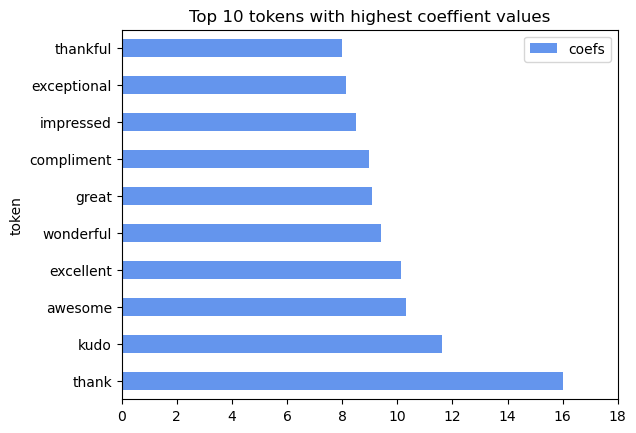

In [63]:
# Plot the top 10 tokens that have the highest coefs
# Grafica los 10 tokens principales que tienen los coeficientes más altos
pos_coef.sort_values('coefs', ascending=False) \
        .plot(kind='barh', 
              xlim=(0, 18),
              x='token',
              color='cornflowerblue',
              title='Top 10 tokens with highest coeffient values');

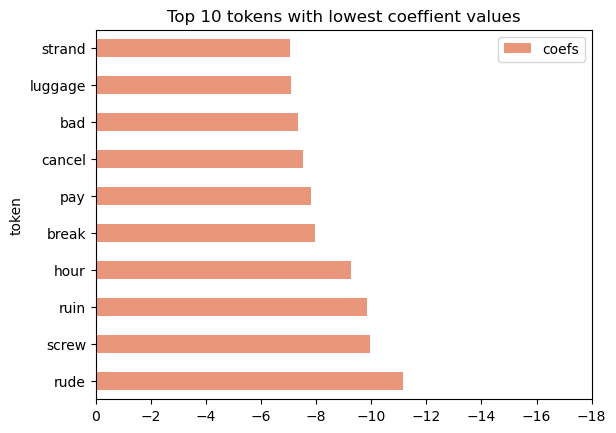

In [64]:
# Plot the top 10 tokens that have the lowest coefs
# Grafica los 10 tokens principales que tienen los coeficientes más bajos
neg_coef.plot(kind='barh', 
              xlim=(0, -18),
              x='token',
              color='darksalmon',
              title='Top 10 tokens with lowest coeffient values');

Palabras como "ruin", "rude" y "hour" son fuertes indicadores de sentimiento negativo, mientras que "thank", "awesome" y "wonderful" se asocian con sentimiento positivo.

Concluiremos la Parte 2 con estos gráficos. Estos términos de coeficiente y las palabras con los valores TF-IDF más altos ofrecen diferentes perspectivas sobre el sentimiento de los tuits. Si lo desea, tómese un tiempo para comparar los dos conjuntos de gráficos y ver cuál refleja mejor los sentimientos transmitidos en los tuits.

<div class="alert alert-success">

## ❗ Key Points

* Una representación de bolsa de palabras es un método sencillo para transformar nuestros datos de texto en números. Se centra en la frecuencia de las palabras, pero no en su orden.
* Una representación TF-IDF va un paso más allá; también considera si una palabra aparece de forma distintiva en un documento o si aparece de forma uniforme en todos los documentos.
* Con una representación numérica, podemos realizar diversas tareas de clasificación de texto, como el análisis de sentimientos.

</div>